# Using Multi-layer Perceptron and Convolutional Neural Networks for Satellite image classification. 

Antonio Fonseca

Packages to be installed:

```
conda install -c conda-forge umap-learn
pip install phate
conda install -c conda-forge imageio
```

In [1]:
import numpy as np
import codecs
import copy
import json
import scipy.io
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
# import phate
# import umap
import pandas as pd 
# import scprep
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
# import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/Users/antonio/opt/anaconda3/envs/geo_comp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


Now that we have an autoencoder working on MNIST, let's use this model to visualize some geodata. For the next section we will use the SAT-6 (https://csc.lsu.edu/~saikat/deepsat/)

SAT-6 consists of a total of 405,000 image patches each of size 28x28 and covering <span style="color:red"> 6 landcover classes - barren land, trees, grassland, roads, buildings and water bodies</span>. 324,000 images (comprising of four-fifths of the total dataset) were chosen as the training dataset and 81,000 (one fifths) were chosen as the testing dataset. Similar to SAT-4, the training and test sets were selected from disjoint NAIP tiles. Once generated, the images in the dataset were randomized in the same way as that for SAT-4. The specifications for the various landcover classes of SAT-4 and SAT-6 were adopted from those used in the National Land Cover Data (NLCD) algorithm. 

The datasets are encoded as MATLAB .mat files that can be read using the standard load command in MATLAB.  <span style="color:red">Each sample image is 28x28 pixels and consists of 4 bands - red, green, blue and near infrared </span>. The training and test labels are 1x4 and 1x6 vectors for SAT-4 and SAT-6 respectively having a single 1 indexing a particular class from 0 through 4 or 6 and 0 values at all other indices.

The MAT file for the SAT-6 dataset contains the following variables:

- train_x	28x28x4x324000 uint8 (containing 324000 training samples of 28x28 images each with 4 channels)
- train_y	324000x6 uint8 (containing 6x1 vectors having labels for the 324000 training samples)
- test_x	28x28x4x81000 uint8 (containing 81000 test samples of 28x28 images each with 4 channels)
- test_y	81000x6 uint8 (containing 6x1 vectors having labels for the 81000 test samples)

Labels:
- Building = 0
- Barren_land = 1
- Tree=2
- Grassland=3
- Road = 4
- Water = 5


In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
from torch import optim, nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# Using the satelite images dataset
###############################################################################
#load the data
data = scipy.io.loadmat("./SAT-4_and_SAT-6_datasets/sat-6-full.mat")
train_images = data['train_x']
train_labels = data['train_y']

test_images = data['test_x']
test_labels = data['test_y']

In [4]:
####################################################################
#Checkout the data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (28, 28, 4, 324000) (6, 324000)
Testing data shape :  (28, 28, 4, 81000) (6, 81000)


In [5]:
#Change the dimension to fit into the model
x_train = train_images.transpose(3,0,1,2)
t_train = train_labels.transpose()

# x_test = test_images.transpose(3,0,1,2)
# t_test = test_labels.transpose()
print('Training data shape : ', x_train.shape, t_train.shape)
# print('Testing data shape : ', x_test.shape, t_test.shape)

Training data shape :  (324000, 28, 28, 4) (324000, 6)


count, t_train[count,:]: 0, [0 0 1 0 0 0]
count, t_train[count,:]: 1, [0 1 0 0 0 0]
count, t_train[count,:]: 2, [0 0 0 0 0 1]
count, t_train[count,:]: 3, [0 0 0 0 0 1]
count, t_train[count,:]: 4, [0 0 0 0 0 1]
count, t_train[count,:]: 5, [1 0 0 0 0 0]
count, t_train[count,:]: 6, [1 0 0 0 0 0]
count, t_train[count,:]: 7, [0 0 0 0 0 1]
count, t_train[count,:]: 8, [0 1 0 0 0 0]
count, t_train[count,:]: 9, [0 0 1 0 0 0]
count, t_train[count,:]: 10, [0 0 0 0 0 1]
count, t_train[count,:]: 11, [0 1 0 0 0 0]
count, t_train[count,:]: 12, [0 1 0 0 0 0]
count, t_train[count,:]: 13, [0 0 0 0 1 0]
count, t_train[count,:]: 14, [0 0 0 0 0 1]
count, t_train[count,:]: 15, [0 0 1 0 0 0]


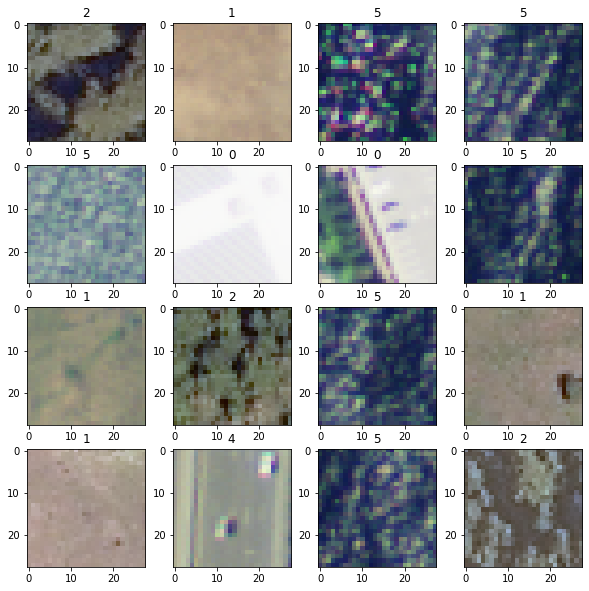

In [6]:
#Check what is in each channel
fig,ax = plt.subplots(4,4, figsize=(10,10))
ax = ax.ravel()
list_idx = np.linspace(0,100,num=16,dtype=np.int64)
for count, idx in enumerate(list_idx):
#     print(idx)
    print('count, t_train[count,:]: {}, {}'.format(count, t_train[count,:]))
#     print(x_train[idx,:,:,0:3])
    ax[count].imshow(x_train[count,:,:,0:3])
    ax[count].set_title(str(np.argmax(t_train[count,:])))

In [7]:
# split in training and testing
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from scipy.ndimage import zoom


class MyDataset(Dataset):
    def __init__(self, data, target):
        print('data.dtype: {}'.format(data.dtype))
        print('target.dtype: {}'.format(target.dtype))
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

print('x_train.shape: {}'.format(x_train.shape))
n_samples = 50000
dataset = MyDataset(x_train[:n_samples,:,:,:], np.argmax(t_train[:n_samples],axis=1))
del x_train, t_train
dataset_size  = len(dataset)
print('dataset_size: {}'.format(dataset_size))
test_split=0.2

batch_size=1024 

# -- split dataset
indices       = list(range(dataset_size))
split         = int(np.floor(test_split*dataset_size))
print('split: {}'.format(split))
# np.random.shuffle(indices) # Randomizing the indices is not a good idea if you want to model the sequence
train_indices, val_indices = indices[split:], indices[:split]

# -- create dataloaders
# #Original
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

dataloaders   = {
    'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler),
    'test': torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler),
    'all': torch.utils.data.DataLoader(dataset,  batch_size=5000, shuffle=False),
    }

x_train.shape: (324000, 28, 28, 4)
data.dtype: uint8
target.dtype: int64
dataset_size: 50000
split: 10000


In [8]:
class FFnet(nn.Module):
    '''
    Linear activation in the middle (instead of an activation function)
    '''
    def __init__(self):
        super(FFnet, self).__init__()
        self.enc_lin1 = nn.Linear(3136, 1000)
        self.enc_lin2 = nn.Linear(1000, 500)
        self.enc_lin3 = nn.Linear(500, 250)
        self.enc_lin4 = nn.Linear(250, 6)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.enc_lin1(x)
        x = self.relu(x)
        x = self.enc_lin2(x)
        x = self.relu(x)
        x = self.enc_lin3(x)
        x = self.relu(x)
        output = self.enc_lin4(x)
        return output

    def forward(self, x):
        z = self.encode(x)
        return z

In [9]:
## Second routine for training and evaluation (using the )
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss or Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100 
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:
            
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose: print('model_input.shape: {}'.format(model_input.shape))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('targets: {}'.format(targets))
                print('out.shape: {}'.format(out.shape))
                print('out: {}'.format(out))

            # Calculate the loss
            targets = targets.type(torch.LongTensor) # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,targets)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            loss_train, acc_train = evaluate(model,train_loader,verbose)
            loss_test, acc_test = evaluate(model,test_loader,verbose)
            print(" Train loss: {:.4f}. Train Acc: {:.4f}, Test loss: {:.4f}. Test Acc: {:.4f}. Time/epoch: {:.4f}".format(loss_train, acc_train, loss_test, acc_test, (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            targets = targets.type(torch.LongTensor)
            loss = loss_fn(out,targets)
        
            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100 * correct / total    
        loss = loss_all/total
    return loss, acc


In [10]:
lr_range = [0.01,0.005,0.001]

for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model, loss_fn, optimizer
    model = FFnet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    loss_fn = nn.CrossEntropyLoss().to(device)
    train(model,loss_fn, optimizer, dataloaders['train'], dataloaders['test'],verbose=False)

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0009. Train Acc: 74.3500, Test loss: 0.0010. Test Acc: 74.3200. Time/epoch: 24.0663
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0002. Train Acc: 90.5100, Test loss: 0.0002. Test Acc: 90.1700. Time/epoch: 21.5834
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0007. Train Acc: 71.4850, Test loss: 0.0007. Test Acc: 72.3100. Time/epoch: 31.5746
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0002. Train Acc: 92.1275, Test loss: 0.0002. Test Acc: 91.4800. Time/epoch: 31.7279
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0002. Train Acc: 92.4675, Test loss: 0.0002. Test Acc: 92.1500. Time/epoch: 34.2578
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.0002. Train Acc: 92.1400, Test loss: 0.0002. Test Acc: 91

In [35]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNNet()

In [38]:
# Training and Evaluation routines
import time
def train(model,loss_fn, optimizer, train_loader, test_loader, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100
    print('n. of epochs: {}'.format(num_epochs))
    for epoch in range(num_epochs+1):
        start = time.time()
        # loop through each data point in the training set
        for data, targets in train_loader:
            
            # run the model on the data
            model_input = data.permute(0, 3, 2, 1).to(device)
            if verbose: print('model_input.shape: {}'.format(model_input.shape))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out = model(model_input) # The second output is the latent representation
            if verbose:
                print('targets.shape: {}'.format(targets.shape))
                print('targets: {}'.format(targets))
                print('out.shape: {}'.format(out.shape))
                print('out: {}'.format(out))

            # Calculate the loss
            targets = targets.type(torch.LongTensor) # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,targets)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()

        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            loss_train, acc_train = evaluate(model,train_loader,verbose)
            loss_test, acc_test = evaluate(model,test_loader,verbose)
            print(" Train loss: {:.4f}. Train Acc: {:.4f}, Test loss: {:.4f}. Test Acc: {:.4f}. Time/epoch: {:.4f}".format(loss_train, acc_train, loss_test, acc_test, (time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        correct = 0
        total = 0
        loss_all=0
        
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.permute(0, 3, 2, 1).to(device)
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            out = model(model_input)
            targets = targets.type(torch.LongTensor)
            loss = loss_fn(out,targets)
        
            if verbose: print('out[:5]: {}'.format(out[:5]))
            loss_all+=loss.item()
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = 100 * correct / total    
        loss = loss_all/total
    return loss, acc


In [39]:
lr_range = [0.01,0.005,0.001]

for lr in lr_range:
    if 'model' in globals():
        print('Deleting previous model')
        del model, loss_fn, optimizer
    model = CNNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.

    loss_fn = nn.CrossEntropyLoss().to(device)
    train(model,loss_fn, optimizer, dataloaders['train'], dataloaders['test'],verbose=False)

Autoencoder - with linear activation in middle layer and non-linearity (tanh) everywhere else
Deleting previous model
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)
n. of epochs: 100
 EPOCH 0. Progress: 0.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 9.6766
 EPOCH 10. Progress: 10.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 9.8254
 EPOCH 20. Progress: 20.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 9.5843
 EPOCH 30. Progress: 30.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 9.4217
 EPOCH 40. Progress: 40.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0.0015. Test Acc: 37.5400. Time/epoch: 9.4936
 EPOCH 50. Progress: 50.0%. 
 Train loss: 0.0015. Train Acc: 36.8250, Test loss: 0

(28, 28, 4)
torch.Size([1, 4, 28, 28])


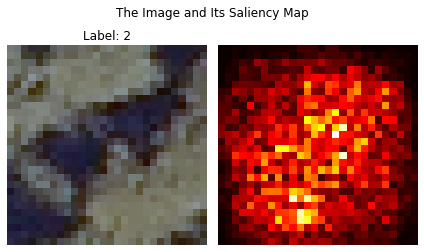

In [106]:
#Change the dimension to fit into the model
x_train = train_images.transpose(3,0,1,2)
t_train = train_labels.transpose()

model.eval()
# with torch.no_grad():

# Retrieve output from the image
idx_to_plot = 0
image = x_train[idx_to_plot,:,:,:]
image_orig = image.copy()
print(image.shape)
image = torch.FloatTensor(image).permute(2, 1, 0).to(device)

# Make input tensor require gradient
    # X.requires_grad_()
image = image[None,:].requires_grad_()
print(image.shape)
output = model(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
saliency = saliency.reshape(28, 28)

# # Reshape the image
# image = image.reshape(-1, 28, 28)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
# x_train[count,:,:,0:3]
# print(image.shape)
# image = image.permute(3, 2, 1,0).squeeze()
# print(image.shape)
ax[0].imshow(image_orig[:,:,0:3])
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
ax[0].set_title('Label: {}'.format(t_train[idx_to_plot].argmax()))
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()